In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

In [2]:
# Set seed for reproducibility
np.random.seed(62)
tf.random.set_seed(62)

# Paths for dataset
DATA_DIR = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

# 1. Prepare data
def prepare_data(data_dir, batch_size=16, target_size=(128, 128), validation_split=0.2):
    """
    Prepare training and validation datasets with data augmentation applied only to the training set.

    Args:
        data_dir (str): Path to the dataset directory.
        batch_size (int): Batch size for the generators.
        target_size (tuple): Target size for the images (height, width).
        validation_split (float): Fraction of data to use for validation.

    Returns:
        train_generator, valid_generator: Data generators for training and validation sets.
    """

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split,  # Set validation split
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation data generator without augmentation
    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split  # Set validation split
    )

    # Train generator (80% of data)
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training'  # Use 80% of the data
    )

    # Validation generator (20% of data)
    valid_generator = valid_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation'  # Use 20% of the data
    )

    return train_generator, valid_generator

In [3]:
# 2. Define model using MobileNetV2
def create_model(input_shape=(128, 128, 3), num_classes=29):
    # Use MobileNetV2 as the base model
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),  # Add batch normalization layer
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),  # Add dropout regularization
        layers.Dense(num_classes, activation='softmax')  # Change num_classes to match your dataset
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# 3. Model checkpoint callback
def checkpoint_callback(save_dir="./checkpoints"):
    """
    Returns a ModelCheckpoint callback to save the best model during training.
    """
    os.makedirs(save_dir, exist_ok=True)
    return ModelCheckpoint(
        os.path.join(save_dir, "best_model.keras"),  # Change extension to .keras
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        mode="min"
    )

In [15]:
# 4. Training function
def train_model(model, train_generator, valid_generator, epochs=20, batch_size=32):
    # Define the device as GPU
    device = '/GPU:0'  # Ensure the device is set to GPU

    with tf.device(device):
        # Callbacks for training
        checkpoint = ModelCheckpoint(
            './checkpoints/best_model.keras',  # Model checkpoint path
            monitor='val_loss', 
            save_best_only=True, 
            mode='min',  # Save the best model based on validation loss
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=5,  # Stop training if no improvement in 5 epochs
            restore_best_weights=True, 
            mode='min', 
            verbose=1
        )

        # Train the model with data generators
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator,
            callbacks=[checkpoint, early_stopping],
            workers=4,  # Number of worker threads to load data in parallel
            use_multiprocessing=True  # Use multiprocessing for data loading
        )
        
    return history

In [ ]:
#5. Training Function with Early Stopping, Checkpoints, and GPU Setup
from tqdm import tqdm
import tensorflow as tf

def train_with_progress(model, train_generator, valid_generator, epochs, optimizer, loss_fn, checkpoint_filepath, early_stopping_patience=3):
    """
    Train the model with progress bars using train and validation data generators,
    and save checkpoints after each epoch. Also includes early stopping.

    Args:
        model (tf.keras.Model): The model to train.
        train_generator (DirectoryIterator): The training data generator.
        valid_generator (DirectoryIterator): The validation data generator.
        epochs (int): Number of training epochs.
        optimizer (tf.keras.optimizers.Optimizer): The optimizer to use.
        loss_fn (tf.keras.losses.Loss): The loss function to use.
        checkpoint_filepath (str): File path for saving the model checkpoints.
        early_stopping_patience (int): Number of epochs with no improvement before stopping.

    Returns:
        History object: Keras History object with training stats.
    """

    # Set GPU if available
    if tf.config.list_physical_devices('GPU'):
        device = '/GPU:0'  # Use the first GPU
        print("Using GPU for training.")
    else:
        device = '/CPU:0'  # Fall back to CPU if no GPU is available
        print("Using CPU for training.")

    # Use the device context for model training
    with tf.device(device):
        # Compile the model with optimizer, loss function, and metrics
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

        # Define callbacks
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                checkpoint_filepath,  # Where to save the model
                save_best_only=True,  # Save only the best model based on validation loss
                monitor='val_loss',  # Monitor validation loss for best model
                mode='min',           # 'min' to save model with minimum validation loss
                verbose=1             # Show progress when saving the model
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for early stopping
                patience=early_stopping_patience,  # Wait for `patience` epochs if no improvement
                mode='min',           # Stop when validation loss has stopped improving
                verbose=1             # Show progress when early stopping is triggered
            )
        ]

        # Train the model with progress bars
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator,
            callbacks=callbacks,  # Add callbacks to model training
            verbose=1             # Show progress bar
        )

    return history

In [13]:
# 6. Visualize training and validation accuracy/loss
def plot_training_history(history):
    """
    Plot the training history for accuracy and loss.
    """
    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [8]:
# 7. Running the complete pipeline
data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

# Prepare datasets
train_generator, valid_generator = prepare_data(data_dir)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [9]:
# Create model
model = create_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Define optimizer, loss function, and callbacks
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

checkpoint_filepath = './checkpoints/best_model.keras'

# Train the model with checkpoints and early stopping
history = train_with_progress(
    model, train_generator, valid_generator, epochs=10, 
    optimizer=optimizer, loss_fn=loss_fn, checkpoint_filepath=checkpoint_filepath, early_stopping_patience=3
)

Using GPU for training.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8315 - loss: 0.5370
Epoch 2: val_loss improved from 1.19405 to 1.15194, saving model to ./checkpoints/best_model.keras
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 389s 89ms/step - accuracy: 0.8315 - loss: 0.5370 - val_accuracy: 0.7752 - val_loss: 1.1519
Epoch 3/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8470 - loss: 0.4838
Epoch 3: val_loss improved from 1.15194 to 1.15069, saving model to ./checkpoints/best_model.keras
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 358s 82ms/step - accuracy: 0.8470 - loss: 0.4838 - val_accuracy: 0.7833 - val_loss: 1.1507
Epoch 4/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8570 - loss: 0.4521
Epoch 4: val_loss did not improve from 1.15069
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 364s 83ms/step - accuracy: 0.8570 - loss: 0.4521 - val_accuracy: 0.7707 - val_loss: 1.4624
Epoch 5/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8738 - loss: 0.4087
Epoch 6: val_loss did not improve from 1.150

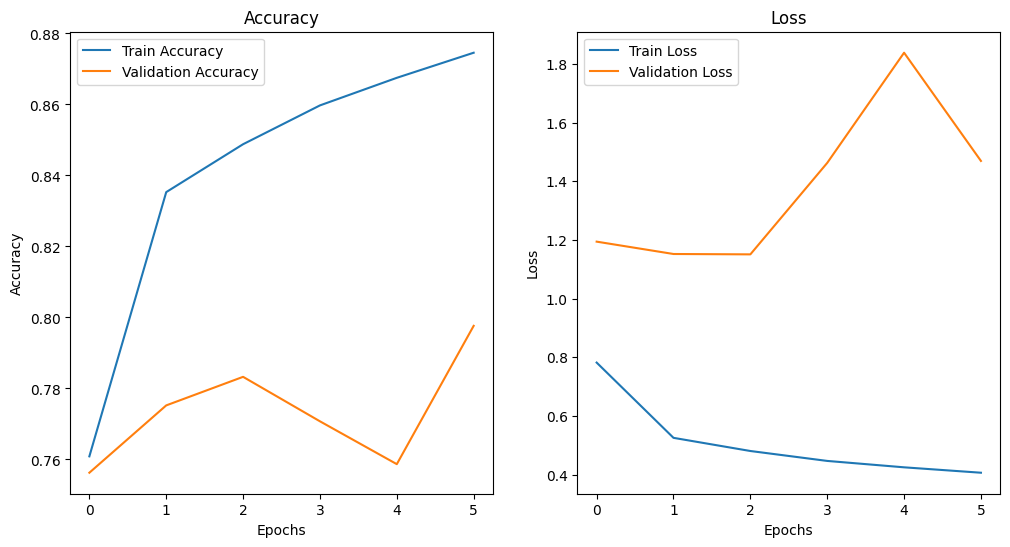

In [14]:
# Plot training history
plot_training_history(history)

In [22]:
# saving models

model_output1 = '/kaggle/working/saved_model.pb'
# model_output2 = '/kaggle/working/saved_model.h5'

model.export(model_output1)
# model.save(model_output2)

Saved artifact at '/kaggle/working/saved_model.pb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  135040371088144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038407314944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038407320576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038407320400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038407317760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038407327264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038396222448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038396219984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038396219456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135038396219632: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [24]:
# Set static input shape (replace `(None, height, width, channels)` with fixed dimensions)
model.build(input_shape=(None, 128, 128, 3))

# Save the model again
model.save(model_output2)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(model_output1)
# tflite_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
# Save the TFLite model
with open("/kaggle/working/model.tflite", "wb") as f:
    f.write(tflite_model)